## Rationale for the visualisation

* generate bins of size 50 from 1 to 1,000
* the *Aeneid* contains 12 books (see dictionary below for consistency)
* create a matrix of 12 rows x 20 columns (dict of dicts)
    * initialise the value of each bin to 0 or None (if the bin scope falls outside the number of lines in the book)
* iterate through the results of the API and increment the count

1. generate empty matrix
2. get and store JSTOR MatchMaker data (quotations)
3. get and store CREX data (references)
4. iterate through quotations and update matrix
5. iterate through references and update matrix
6. output data in a d3.js-friendly JSON format

In [4]:
ll ../data/

total 42832
-rw-rw-r-- 1 mromanello    57721 Aug 11 11:35 aeneid.json
-rwxr--r-- 1 mromanello  1572864 Aug 18 11:01 citedloci_api_output.json*
-rw-rw-r-- 1 mromanello 41306724 Aug 11 12:36 matchmaker_api_output.json
-rwxrwxr-x 1 mromanello   758146 Aug 11 11:35 perseus_aeneid.json*
-rw-rw-r-- 1 mromanello   114891 Aug 11 12:58 quot_freq3.json
-rw-rw-r-- 1 mromanello    11298 Aug 11 11:35 quot_freq_empty2.json
-rw-rw-r-- 1 mromanello     1290 Aug 11 11:35 quot_freq_empty.json
-rw-rw-r-- 1 mromanello    18376 Aug 11 12:21 test.json


In [7]:
import matplotlib; matplotlib.use('Agg')
%matplotlib inline
import ConfigParser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import json
import requests
import seaborn as sns;sns.set()
import codecs
from MyCapytain.common.reference import URN

In [118]:
def create_matrix():
    """
    TODO.
    """
    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in xrange(0, len(l), n):
            yield l[i:i+n]
    # the number of lines for each book in the Aeneid
    # keys are book numbers, values are numbers of lines
    book_upper_boundaries = {
        1:756
        ,2:804
        ,3:719
        ,4:705
        ,5:871
        ,6:901
        ,7:817
        ,8:731
        ,9:818
        ,10:908
        ,11:915
        ,12:952
    }
    quotation_freq_matrix = {}
    chunks = {(chunk[0],chunk[-1]):chunk for chunk in list(chunks(range(1,1001),50))}
    for book_number in sorted(book_upper_boundaries.keys()):
        max_line_number = book_upper_boundaries[book_number]
        temp = {}
        for range_start,range_end in chunks.keys():
            if (range_start < max_line_number and range_end <= max_line_number):
                temp["%i-%i"%(range_start,range_end)] = {"reference_count":0,"quotation_count":0,"results":set()}
            elif(range_start < max_line_number and range_end > max_line_number):
                temp["%i-%i"%(range_start,range_end)] = {"reference_count":0,"quotation_count":0,"results":set()}
            else:
                temp["%i-%i"%(range_start,range_end)] = np.nan
        quotation_freq_matrix[book_number] = temp
        df = pd.DataFrame.from_dict(quotation_freq_matrix)
    return df.reindex_axis(sorted(df.index
                                ,key=lambda x: int(x.split('-')[0]))
                                 ,axis=0), chunks

In [9]:
def save_matrix_as_json(matrix, filepath):
    """
    Saves the matrix in a JSON and d3-friendly format.
    """
    import codecs
    import json
    try:
        data = json.loads(matrix.to_json(orient="split"))
        reshaped_data = [{"chunk":data["index"][i]
                  ,"book":data["columns"][j]
                  ,"counts":book} for i,chunk in enumerate(data["data"]) 
                                                             for j,book in enumerate(chunk)]
        json.dump(reshaped_data, codecs.open(filepath,"w","utf-8"))
        return True
    except Exception as e:
        print e
        return False

## Create an empty matrix data structure for the Aeneid

columns = books; rows = line chunks of size n=50

In [47]:
df,chunks = create_matrix()

In [28]:
#df.head()

In [30]:
save_matrix_as_json(df, "../data/test.json") # we let pandas serialize it as json, as it's very good at it

True

## Query the MatchMaker API

In [37]:
def get_aeneid_quotations_in_JSTOR(path_credentials="authentication.conf"):
    """
    TODO
    """
    matchmaker_endpoint = "http://labs.jstor.org/apis/matchmaker/"
    parameters = {'work':'virgil_aeneid','limit':50000}
    config = ConfigParser.ConfigParser(allow_no_value=True)
    config.read(path_credentials)
    credentials = (config.get("jstor","user"), config.get("jstor","pwd"))
    response = requests.get(matchmaker_endpoint
                            , params=parameters
                            , auth=credentials)
    data = response.json()
    for doc in data["docs"]:
        doc["chunk_urns"]  = [chunk_id.replace('<verg. aen. ','urn:cts:latinLit:phi0690.phi003:').replace('>','')
                                                                                   for chunk_id in doc["chunk_ids"]]
    return data

In [38]:
mm_data = get_aeneid_quotations_in_JSTOR()

In [43]:
json.dump(mm_data,codecs.open("../data/matchmaker_api_output.json","w","utf-8"))

### Iterate over the data and update the quotation frequency count

In [5]:
from flask_restful import marshal, fields

Create a new empy matrix where to store the data and counts:

In [146]:
quotation_freq_df,chunks = create_matrix()

Load the data that were previously fetched via the API and stored into a file

In [147]:
data = json.load(codecs.open("../data/matchmaker_api_output.json","r","utf-8"))

In [148]:
#data["docs"][2]

Now define the fields for marshalling data into a new JSON structure

In [149]:
quotation_fields = {
    "document":{
        "doi": fields.String(attribute="docid")
        ,"year":fields.Raw(attribute="pubyear")
        ,"pubdate":fields.String
        ,"journaltitle":fields.String(attribute="journal")
        ,"author": fields.List(fields.String, attribute="authors")
    }
    ,"id": fields.String
    ,"snippet":fields.String
    ,"all_urns":fields.List(fields.String, attribute="chunk_urns")
}

Transform the quotation records into an index: `quotation_id` => `quotation_record`

In [150]:
quotations = {doc["id"]: dict(marshal(doc,quotation_fields)) for doc in data["docs"]}

In [151]:
quoted_urns = [(urn,doc["id"]) for doc in data["docs"] for urn in doc["chunk_urns"]]

In [152]:
len(quoted_urns)

29941

In [19]:
#quoted_urns[:1]

[(u'urn:cts:latinLit:phi0690.phi003:1.48',
  u'000395a29c586c8ca10e4bbade544dde')]

Go trough all quotations and add each `quotation_id` to the chunk where it falls:

In [153]:
for urn, quotation_id in quoted_urns:
    quoted_urn = URN(urn)
    book_n, line_n = quoted_urn.reference.list
    book_n = int(book_n)
    line_n = int(line_n)
    for start_range,end_range in chunks:
        # find the chunk in which the line falls
        if (line_n >= start_range and line_n <= end_range):
            if(quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n] is not np.nan):
                #quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n]["quotation_count"] +=1 
                quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n]["results"].add(('quotation'
                                                                                               , quotation_id))

In [26]:
#quotation_freq_df.loc["1-50"][1]["results"]

{('quotation', u'000395a29c586c8ca10e4bbade544dde'),
 ('quotation', u'00192bb4cee556ebcf39d1fd2cebc063'),
 ('quotation', u'0248a034f950cf037a4e5f24be9516aa'),
 ('quotation', u'03092a060b63e5daebb3d232aec3d19b'),
 ('quotation', u'0382803b8415f0dbb617de87321db089'),
 ('quotation', u'048beffd0fe6895b48a9dc67c8610d66'),
 ('quotation', u'05b85c7c73190a493e234fb0fe2222a6'),
 ('quotation', u'06be8dd2df8bd4bd05f916a7394ce2e7'),
 ('quotation', u'08091d46c47e89bbb0c37628e0b82a62'),
 ('quotation', u'0a5a287247bcb1707716a32966c110e7'),
 ('quotation', u'0a7fdb05120fe6be4b668864baf6d506'),
 ('quotation', u'0a9c70923626a2e973281cd493c8a856'),
 ('quotation', u'0b2f4098ec1fe489fd7a7e547b85036c'),
 ('quotation', u'0b771fb9bcfa9d78bd2471165fcbf04b'),
 ('quotation', u'0c0f852bc7afa4925cfd48857a78d3a0'),
 ('quotation', u'0ce9b05ac758fd39b7e4b6a7cb2f6df7'),
 ('quotation', u'0db4987750ac8459fc72614930d171f2'),
 ('quotation', u'0ddd2adc2079b7481dff3228208213d2'),
 ('quotation', u'0e3b02b048481b42910095f75d650

In [154]:
for chunk in quotation_freq_df.index:
    for book in quotation_freq_df.loc[chunk]:
        if book is not np.nan:
            book["quotation_count"] = len(book["results"])
            book["results"]  = [quotations[record_id] for record_type, record_id in book["results"] 
                                                                                   if record_type=="quotation"]
            for record in book["results"]:
                # TODO: parse pubdate into a datetime obj
                record["type"] = "quotation"
                record["document"]["url"] = "%s%s"%("http://www.jstor.org/stable/",record["document"]["doi"])

In [155]:
save_matrix_as_json(quotation_freq_df, "../data/quot_freq5.json")

True

## Query the CitedLoci API

### Load the data about references to the Aeneid

In [22]:
my_data = json.load(codecs.open("../data/citedloci_api_output.json","r","utf-8"))

In [24]:
my_data["result"][0]

{u'document': {u'doi': u'10.2307/1562134',
  u'title': u'The Way We Used to Eat: Diet_ Community_ and History at Rome'},
 u'line_number': 252,
 u'reference_type': u'scope',
 u'snippet': u'Another preoccupation of the De gente, which is inviting for the cultural historian, was what, and from which people, the Romans copied : "quid a quaque traxerint gente per imitationem" (fr. 21 Peter, Servius, ad <em>Aen.</em> <em>7.176).</em>',
 u'surface': u'Aen. 7.176).',
 u'urns': {u'author_urn': u'urn:cts:latinLit:phi0690',
  u'reference_urn': u'urn:cts:latinLit:phi0690.phi003:7.176',
  u'work_urn': u'urn:cts:latinLit:phi0690.phi003'}}

In [40]:
referenced_urns = [(doc["urns"]["reference_urn"]
                    ,URN(doc["urns"]["reference_urn"]).reference.list) for doc in my_data["result"]
                                                    if URN(doc["urns"]["reference_urn"]).reference.list is not None
                                                      and len(URN(doc["urns"]["reference_urn"]).reference.list)==2]

In [41]:
len(referenced_urns)

12056

In [46]:
referenced_urns[:1]

[(u'urn:cts:latinLit:phi0690.phi003:7.176', [u'7', u'176'])]

In [53]:
invalid_citations = []
for urn in referenced_urns:
    referenced_urn = URN(urn[0])
    book_n, line_n = referenced_urn.reference.list
    book_n = int(book_n)
    line_n = int(line_n)
    for start_range,end_range in chunks:
        # find the chunk in which the line falls
        if (line_n >= start_range and line_n <= end_range):
            try:
                if(quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n] is not np.nan):
                    quotation_freq_df.loc["%i-%i"%(start_range,end_range)][book_n]["reference_count"] +=1 
            except Exception as e:
                invalid_citations.append(urn[0])

In [58]:
save_matrix_as_json(quotation_freq_df, "../data/quot_freq4.json")

True

## Plot

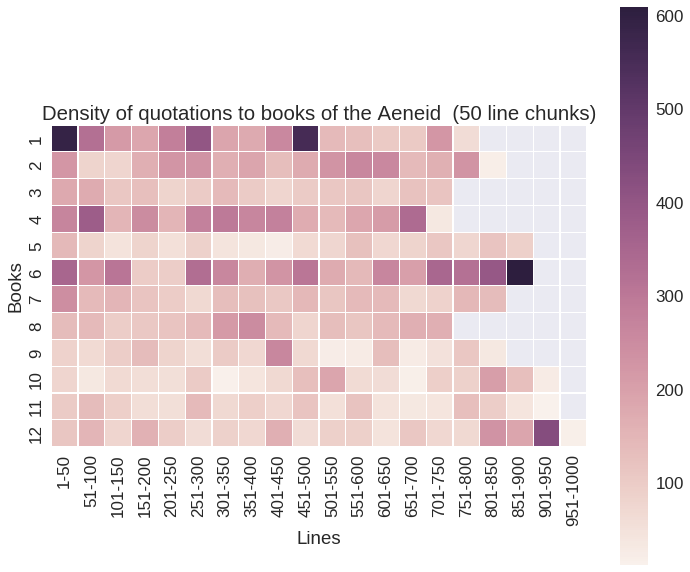

In [16]:
sns.set_context("notebook", font_scale=1.7)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(quotation_freq_df,square=True,linewidths=.2)
ax.set_title("Density of quotations to books of the Aeneid  (50 line chunks)")
ax.set_xlabel('Lines')
ax.set_ylabel('Books')

In [17]:
ax.figure.savefig('quotation_freq_heatmap.png')


## Get the Latin text of the Aeneid from Perseus

http://cts.perseids.org/api/cts/?request=GetPassagePlus&urn=urn:cts:latinLit:phi0690.phi003:1.1


or simply download this https://github.com/PerseusDL/canonical-latinLit/blob/master/data/phi0690/phi003/phi0690.phi003.perseus-lat2.xml

and parse it with BeautifoulSoup...

In [1]:
import urllib2
import bs4
from bs4 import BeautifulSoup

In [2]:
perseus_aeneid_latin = "https://raw.githubusercontent.com/PerseusDL/canonical-latinLit/master/data/phi0690/phi003/phi0690.phi003.perseus-lat2.xml"
soup = BeautifulSoup(urllib2.urlopen(perseus_aeneid_latin).read(),"xml")
divs = soup.find_all("div",subtype="book",type="textpart")

FeatureNotFound: Couldn't find a tree builder with the features you requested: xml. Do you need to install a parser library?

In [3]:
def create_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

chunks = {(bin[0],bin[-1]):bin for bin in list(create_chunks(range(1,1001),50))}

In [4]:
def find_chunk(line_number, chunks):
    for start_line, end_line in chunks:
        if(line_number >= start_line and line_number <= end_line):
            return start_line,end_line

In [ ]:
text = {}
for div in divs:
    text[div["n"]] = {"%i-%i"%(start_line,end_line):[] for start_line, end_line in chunks}

In [ ]:
for div in divs:
    lines = div.find_all("l")
    for line in lines:
        if(not line["n"]=="62b"):
            text[div["n"]]["%i-%i"%(find_chunk(int(line["n"]),chunks))].append({"line":"%s.%s"%(div["n"],line["n"]),"text":line.text})
        else:
            prev_line = text[div["n"]]["%i-%i"%(find_chunk(int(line["n"][:-1]),chunks))].pop()
            prev_line["text"] = "%s %s"%(prev_line["text"],line.text)
            text[div["n"]]["%i-%i"%(find_chunk(int(line["n"][:-1]),chunks))].append(prev_line)§

In [ ]:
output = []
for book_n in text.keys():
    for chunk in text[book_n].keys():
        temp = {
        "book": book_n
        ,"chunk" : chunk
        ,"lines" : text[book_n][chunk]
    }
        output.append(temp)
        

In [ ]:
outf = codecs.open("/media/romanell_files/tmp/aeneid.json","w","utf-8")
json.dump(output,outf,encoding="utf-8")
outf.close()